In [100]:
%%capture
#!/usr/bin/env python
import sys
sys.path.insert(0, './gym-snake/')
import gym
import time
from optparse import OptionParser
import gym_snake
from gym_snake.envs.constants import GridType, Action4, Action6
from PyQt5.QtCore import Qt

from gym import wrappers
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

__author__ = "Malthe Faurschou Tøttrup"
__email__ = "malthe@toettrup.dk"

is_done = False


# Load the gym environment
env = gym.make('Snake-8x8-v0')

def resetEnv():
    global is_done

    is_done = False
    env.reset()

resetEnv()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [101]:
#Reward shaping


In [102]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [103]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(16, interpolation=Image.BOX),
                    T.ToTensor()])
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))

    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW) #TODO: CHANGE
    return resize(screen).unsqueeze(0)


c:\Users\Malthe\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [104]:
class DQN_CNN(nn.Module):
    
    def __init__(self, outputs):
        super(DQN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding='same')
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(256, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.bn1(x)
        x = self.fc1(x.view(x.size(0), -1))
        return x
    
class DQN_DeepMind(nn.Module):
        
    def __init__(self, outputs):
        super(DQN_DeepMind, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, padding='valid', stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, padding='valid', stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding='valid', stride=1)
        self.fc1 = nn.Linear(1024, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.fc1(x.view(x.size(0), -1))
        return x

In [105]:
""" Hyperparameters """
BATCH_SIZE = 256
GAMMA = 0.95
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 5000
TARGET_UPDATE = 1000
learning_rate = 1e-4  # learning rate (default: 1e-4)
decay_rate = 0.99 # decay rate for RMSprop (default: 0.99)
num_episodes = 10000
MEMORY_SIZE = 10000

In [106]:
""" Network initialization """

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
# screen_height, screen_width, _ = screen = env.render(mode='rgb_array').shape 

# Get number of actions from gym action space
n_actions = env.action_space.n

""" Initialize policy net and target net """
policy_net = DQN_CNN(n_actions).to(device)
target_net = DQN_CNN(n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

""" Optimizer """
#ref: https://ai.stackexchange.com/questions/9298/neural-network-optimizers-in-reinforcement-learning-non-well-behaved-environment
#optimizer = optim.RMSprop(policy_net.parameters(), lr=learning_rate, weight_decay=decay_rate) 
#optimizer = optim.RMSprop(policy_net.parameters())
optimizer = optim.Adam(policy_net.parameters())
#optimizer = optim.SGD(policy_net.parameters())


""" Loss function """
#criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
#criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()

""" Initialize experince memory """
memory = ReplayMemory(MEMORY_SIZE)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())

In [107]:
""" Model Optimization """

losses = []
mean_loss = []
def optimize_model():
        
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
                                          
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute Huber loss
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    losses.append(loss.to('cpu').detach().numpy())
    mean_loss.append(np.mean(losses))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()



In [108]:
""" Training """

num_model = "CNN"
save_path = 'models/snakeai'+str(num_model)+'.pkl'

episode_reward = 0
rewards = []
moveing_average_rewards = []

for i_episode in range(num_episodes):

    episode_reward = 0

    if i_episode % 100 == 0 and i_episode != 0:
        print("playing episode: ", i_episode,"/",num_episodes, 
        " mean loss => ", round(mean_loss[-1],4),
        "mean reward => ", round(moveing_average_rewards[-1], 4))

    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen + last_screen


    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        episode_reward += reward

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen + last_screen
        else:
            next_state = None

        # Store the transition in memory
        #if(len(memory) < 10000): #fixing the experience in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        
        optimize_model()
        
        if done:
            rewards.append(episode_reward.item())
            # Take the mean of the last 100 rewards
            moveing_average_rewards.append(np.mean(rewards[-100:]))
            episode_durations.append(t + 1)
            break

        # Update the target network, copying all weights and biases in DQN
        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
            torch.save(target_net.state_dict(), save_path)

print('Complete')
env.close()
plt.plot(rewards)
plt.plot(moveing_average_rewards)
plt.ioff()
plt.show()
plot_durations()

c:\Users\Malthe\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:280: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


playing episode:  100 / 10000  mean loss =>  0.0596 mean reward =>  -0.95
playing episode:  200 / 10000  mean loss =>  0.0618 mean reward =>  -0.87
playing episode:  300 / 10000  mean loss =>  0.0578 mean reward =>  -0.91
playing episode:  400 / 10000  mean loss =>  0.0438 mean reward =>  -0.88
playing episode:  500 / 10000  mean loss =>  0.0325 mean reward =>  -0.79
playing episode:  600 / 10000  mean loss =>  0.0221 mean reward =>  -0.41
playing episode:  700 / 10000  mean loss =>  0.0164 mean reward =>  0.15
playing episode:  800 / 10000  mean loss =>  0.0147 mean reward =>  0.52
playing episode:  900 / 10000  mean loss =>  0.0143 mean reward =>  0.2
playing episode:  1000 / 10000  mean loss =>  0.0141 mean reward =>  0.35
playing episode:  1100 / 10000  mean loss =>  0.0143 mean reward =>  0.71
playing episode:  1200 / 10000  mean loss =>  0.0146 mean reward =>  0.75
playing episode:  1300 / 10000  mean loss =>  0.015 mean reward =>  0.79
playing episode:  1400 / 10000  mean loss =

KeyboardInterrupt: 

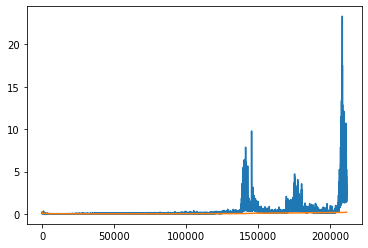

In [109]:
plt.plot(losses)
plt.plot(mean_loss)

In [110]:
""" Record 10 videos """

training = False

if(not training):
    def select_action(state):
        return target_net(state).max(1)[1].view(1, 1)

    num_episodes = 10

    env = gym.wrappers.RecordVideo(env, 'video/CNN', episode_trigger = lambda x: x % 1 == 0)

    episode_reward = 0
    rewards = []

    for i_episode in range(num_episodes):

        # Initialize the environment and state
        env.reset()
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen + last_screen

        for t in count():
            # Select and perform an action
            action = select_action(state)
            _, reward, done, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            episode_reward += reward

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen()
            if not done:
                next_state = current_screen + last_screen
            else:
                next_state = None

            # Move to the next state
            state = next_state

            if done:
                rewards.append(episode_reward.item())
                #plot_durations()
                break

c:\Users\Malthe\anaconda3\lib\site-packages\gym\wrappers\record_video.py:78: UserWarning: WARN: Overwriting existing videos at c:\Users\Malthe\dl-project-grp21\src\video\CNN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
